In [75]:
import os
import sys
import tarfile
import cPickle as pickle
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

## The SVHN dataset (32-by-32 images)

The SVHN dataset also comes in another format. MNIST-like 32-by-32 images centered around a single character (many of the images do contain some distractors at the sides).

Character level ground truth in an MNIST-like format. All digits have been resized to a fixed resolution of 32-by-32 pixels. The original character bounding boxes are extended in the appropriate dimension to become square windows, so that resizing them to 32-by-32 pixels does not introduce aspect ratio distortions. Nevertheless this preprocessing introduces some distracting digits to the sides of the digit of interest. Loading the .mat files creates 2 variables: X which is a 4-D matrix containing the images, and y which is a vector of class labels. To access the images, X(:,:,:,i) gives the i-th 32-by-32 RGB image, with class label y(i). 

In [3]:
from scipy.io import loadmat

def load_data(path):
    data = loadmat(path)
    return data['X'], data['y']

X_train, y_train = load_data('data/train_32x32.mat')
X_test, y_test = load_data('data/test_32x32.mat')
X_extra, y_extra = load_data('data/extra_32x32.mat')

print("Training", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)
print('Extra', X_extra.shape, y_extra.shape)

('Training', (32, 32, 3, 73257), (73257, 1))
('Test', (32, 32, 3, 26032), (26032, 1))
('Extra', (32, 32, 3, 531131), (531131, 1))


Let's transpose the data to get a more manageable format

In [4]:
X_train, y_train = X_train.transpose((3,0,1,2)), y_train[:,0]
X_test, y_test = X_test.transpose((3,0,1,2)), y_test[:,0]
X_extra, y_extra = X_extra.transpose((3,0,1,2)), y_extra[:,0]

print("Training", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)
print('Extra', X_extra.shape, y_extra.shape)

print("\nBaseline")
print(X_train.shape[0] + X_test.shape[0] + X_extra.shape[0])

('Training', (73257, 32, 32, 3), (73257,))
('Test', (26032, 32, 32, 3), (26032,))
('Extra', (531131, 32, 32, 3), (531131,))

Baseline
630420


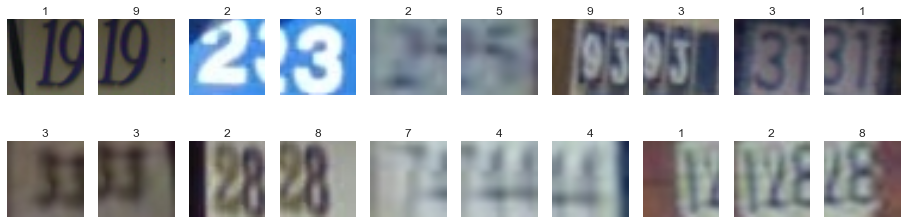

In [5]:
def display_numbers(img, labels, nrows, ncols):
    """Helper function used to display digits"""
    plt.figure(figsize=(min(16, ncols*2), min(16, nrows*2)))
    for i in range(nrows * ncols):
        plt.subplot(nrows, ncols, i+1)
        if img[i].shape == (32, 32, 3): # if rgb image
            image = img[i,:,:,:]
        else: # if grayscale
            image = img[i]
        plt.imshow(image)
        plt.xticks([]); plt.yticks([])
        plt.title(labels[i])
        
display_numbers(X_train, y_train, 2, 10)

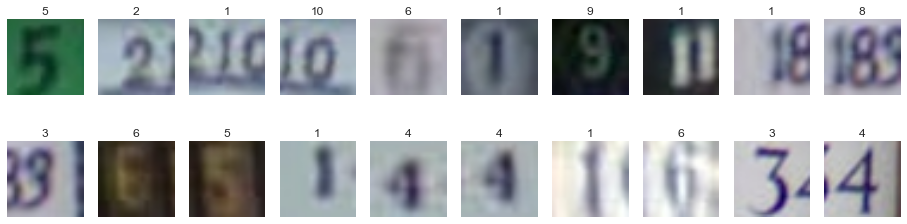

In [6]:
display_numbers(X_test, y_test, 2, 10)

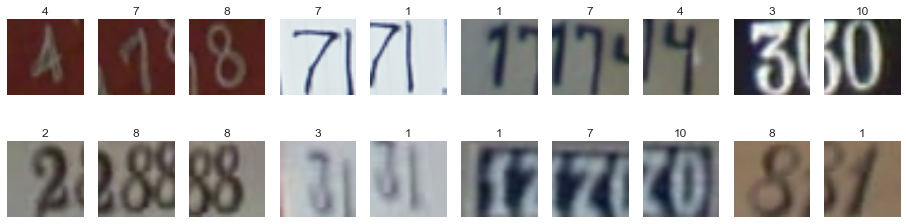

In [7]:
display_numbers(X_extra, y_extra, 2, 10)

For some reason we can see that images of zeros are labeled 10 in the upper right corner.

In [10]:
print(np.unique(y_train))

[ 1  2  3  4  5  6  7  8  9 10]


### Basic Preprocessing

https://arxiv.org/pdf/1204.3968.pdf

The SVHN classification dataset [8] contains 32x32 images with 3 color channels. The dataset is divided into three subsets: train set, extra set and test set. The extra set is a large set of easy samples and train set is a smaller set of more difficult samples. Since we are given no information about how the sampling of these images was done, we assume a random order to construct our validation set. We compose our validation set with 2/3 from training samples (400 per class) and 1/3 from extra samples (200 per class), yielding a total of 6000 samples. This distribution allows to measure success on easy samples but puts more emphasis on difficult ones.

**Set labels of zero values to 0**

In [11]:
# Set labels for zeros to 0
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0
y_extra[y_extra == 10] = 0

**Create a balanced validation set**

In [12]:
def balanced_subsample(y, sample_size):
    """ Return the indices of a balanced subsample by sampling all classes with sample_size"""
    subsample = []
    # For every class in the dataset
    for label in np.unique(y):
        samples = np.where(y==label)[0]
        # Select a random sample with sample size
        indexes = np.random.choice(samples, size=sample_size, replace=False)
        subsample += indexes.tolist()
    return subsample

In [13]:
# Pick 400 samples per class from the training samples
train_samples = balanced_subsample(y_train, 400)
valid_data, valid_labels = np.copy(X_train[train_samples]), np.copy(y_train[train_samples])
# Remove the samples to avoid duplicates
X_train = np.delete(X_train, train_samples, axis=0)
y_train = np.delete(y_train, train_samples, axis=0)

# Pick 200 samples per class from the extra samples
extra_samples = balanced_subsample(y_extra, 200)
valid_data = np.concatenate([valid_data, np.copy(X_extra[extra_samples])])
valid_labels = np.concatenate([valid_labels, np.copy(y_extra[extra_samples])])
# Remove the samples to avoid duplicates
X_extra = np.delete(X_extra, extra_samples, axis=0)
y_extra = np.delete(y_extra, extra_samples, axis=0)

In [14]:
train_data = np.concatenate([X_train, X_extra])
train_labels = np.concatenate([y_train, y_extra])
test_data, test_labels = X_test, y_test

print("Training", train_data.shape, train_labels.shape)
print("Test", test_data.shape, test_labels.shape)
print('Validation', valid_data.shape, valid_labels.shape)

('Training', (598388, 32, 32, 3), (598388,))
('Test', (26032, 32, 32, 3), (26032,))
('Validation', (6000, 32, 32, 3), (6000,))


### Sanity Check

Sanity check
630420


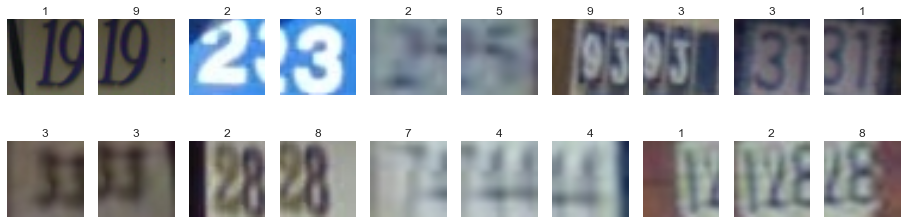

In [15]:
print("Sanity check")
print(train_data.shape[0] + test_data.shape[0] + valid_data.shape[0])

display_numbers(train_data, train_labels, 2, 10)

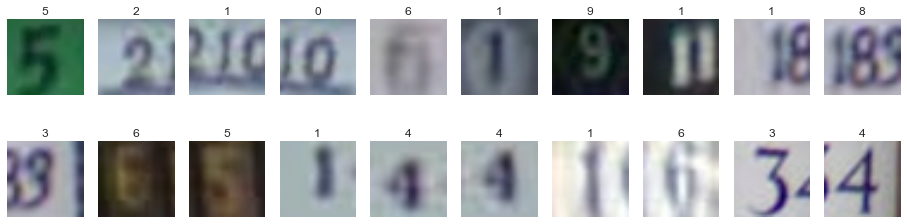

In [16]:
display_numbers(test_data, test_labels, 2, 10)

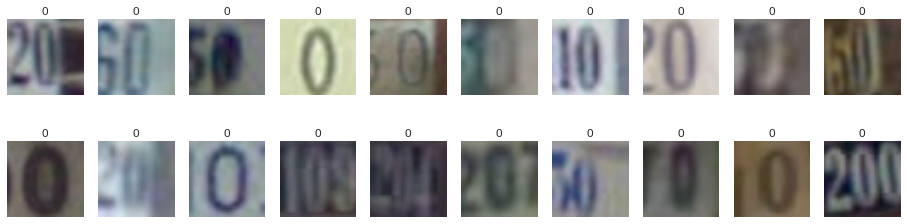

In [17]:
display_numbers(valid_data, valid_labels, 2, 10)

## Preprocessing

https://cs231n.github.io/neural-networks-2/#datapre

Samples are pre-processed with a local contrast normalization(with a 7x7 kernel) on the Y channel of the YUV space followed by a global contrast normalization over each channel. No sample distortions were used to improve invariance

**Convert to Grayscale**

Let's implement a function to convert our images to grayscale.

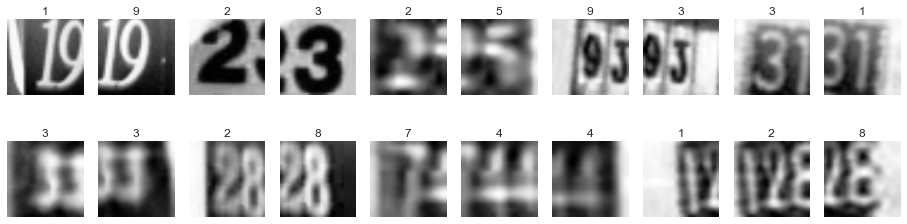

In [26]:
def rgb2gray(images):
    """Convert images from rbg to grayscale"""
    return np.dot(images, [0.2999, 0.587, 0.114])
    
gray_test = rgb2gray(train_data[:20])

display_numbers(gray_test, train_labels[:20], 2, 10)

**Local Contrast Normalization**

In [91]:
def lcn(img):
    """"""
    return

**Global Contrast Normalization**

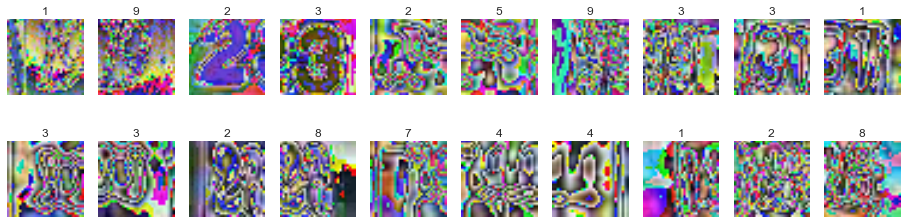

In [90]:
def gcn(image, epsilon=1e-4):
    """Global Contrast Normalization"""
    mean = np.mean(image, axis=(1, 2))
    std = np.std(image, axis=(1,2), ddof=1)
    std[std < epsilon] = 1.
    image_GCN = np.zeros(image.shape, dtype=float)
    for i in np.arange(image.shape[0]):
        image_GCN[i,:,:] = (image[i,:,:] - mean[i]) / std[i]
    return image_GCN

gcn_images = gcn(train_data[:20])

display_numbers(gcn_images, train_labels, 2, 10)

**ZCA Whitening**

In [89]:
def zca_whitening_matrix(X):
    """ Function to compute ZCA whitening matrix """
    return

## Storing the Changes

In [76]:
pickle_file = 'SVHN.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_data,
        'train_labels': train_labels,
        'valid_dataset': valid_data,
        'valid_labels': valid_labels,
        'test_dataset': test_data,
        'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

('Compressed pickle size:', 1937281075)
